# Algorithm prototyping

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely as sh
import shapely.geometry as shg
import shapely.ops as sho
from datetime import datetime

In [2]:
from pyproj import CRS, Transformer

In [3]:
%matplotlib inline

## Helper functions

In [4]:
crs_4326 = CRS.from_epsg(4326) # WGS84
crs_25832 = CRS.from_epsg(25832) # ETRS89 / UTM zone 32N
to_wgs_84_transformer = Transformer.from_crs(crs_25832, crs_4326)
to_utm_transformer = Transformer.from_crs(crs_4326, crs_25832)

In [57]:
df = pd.read_csv("data\extracted\dom1l-fp_32349_5660_1_nw.csv")

In [58]:
df = df.sample(50000)

In [59]:
df = gpd.GeoDataFrame(df)

In [60]:
df.head()

,x,y,z,lat,lon
5054675,349711.01,5660228.61,48.14,51.073867,6.854691
1261063,349149.77,5660707.60,43.79,51.078024,6.846485
794640,349093.88,5660981.36,45.69,51.080470,6.845574
4993455,349694.66,5660559.25,36.52,51.076834,6.854320
767150,349090.90,5660739.87,57.42,51.078299,6.845632


In [61]:
# creating a geometry column 
geometry = [sh.geometry.Point(xy) for xy in zip(df['lon'], df['lat'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

In [62]:
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df[["x", "y", "z"]], crs=crs, geometry=geometry)

In [63]:
gdf.head()

,x,y,z,geometry
5054675,349711.01,5660228.61,48.14,POINT (6.854690566643537 51.07386745912146)
1261063,349149.77,5660707.60,43.79,POINT (6.846485284062434 51.07802442609893)
794640,349093.88,5660981.36,45.69,POINT (6.845573711003929 51.08046974174578)
4993455,349694.66,5660559.25,36.52,POINT (6.854319884494897 51.07683433223707)
767150,349090.90,5660739.87,57.42,POINT (6.845632028268813 51.07829892534033)


In [64]:
lat_q, lon_q = 51.078534, 6.844748
query_point = shg.Point(lat_q, lon_q)

In [75]:
# filter to 100m around query point first
R = 50
query_point_xy = shg.Point(to_utm_transformer.transform(lon_q, lat_q))
query_region_xy = query_point_xy.buffer(R, resolution=16)
query_region_wgs84 = sho.transform(to_wgs_84_transformer.transform, query_region_xy)

In [76]:
gdf_query = gdf[gdf.intersects(query_region_wgs84)]

In [77]:
len(gdf_query), len(gdf)

(168, 50000)

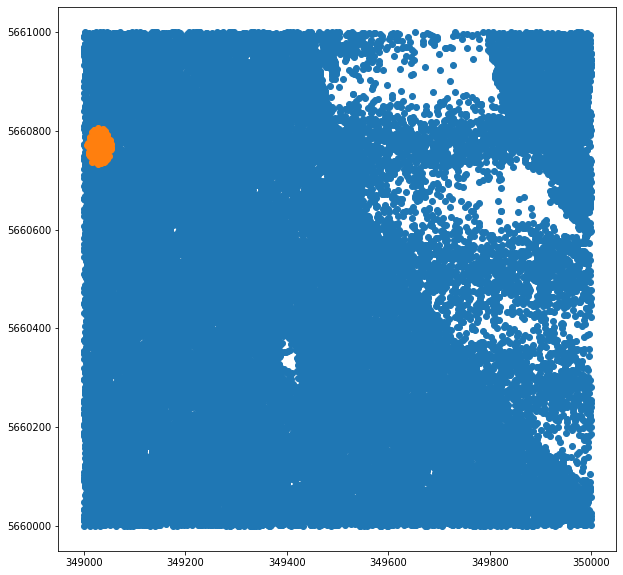

In [78]:
plt.figure(figsize=(10,10))
plt.scatter(gdf["x"], gdf["y"])
plt.scatter(gdf_query["x"], gdf_query["y"])

In [84]:
# get nearest point to the query point
query_nearest_point = gdf_query.loc[gdf_query.distance(sh.geometry.Point(lon_q, lat_q)).idxmin()]

This point is now the origin of the projected axis, so we have to remove the offset of other points

In [86]:
query_nearest_point

x                                                349027
y                                           5.66077e+06
z                                                 43.97
geometry    POINT (6.844702615635597 51.07853145210984)
Name: 211700, dtype: object

In [87]:
gdf_query["x_proj"] = gdf_query["x"] - query_nearest_point["x"]
gdf_query["y_proj"] = gdf_query["y"] - query_nearest_point["y"]

c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
gdf_query.head()

,x,y,z,geometry,x_proj,y_proj
302152,349038.27,5660744.67,43.97,POINT (6.844879250309894 51.07832821420593),11.71,-22.96
283881,349035.98,5660796.55,44.07,POINT (6.844824914852152 51.07879380599026),9.42,28.92
156246,349019.42,5660770.34,46.83,POINT (6.844599630211593 51.07855392553117),-7.14,2.71
186458,349023.27,5660791.53,46.47,POINT (6.844645700156561 51.07874535210168),-3.29,23.90
97177,349012.06,5660786.86,43.86,POINT (6.84448773749141 51.078700437756),-14.50,19.23


## Sunstate

In [90]:
query_time = datetime(2019, 7, 21, 9, 0, 0)